## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-12-31T00:00:00.0000000Z', 'time_period_end': '2024-01-01T00:00:00.0000000Z', 'time_open': '2023-12-31T00:00:40.0740000Z', 'time_close': '2023-12-31T21:39:13.4370000Z', 'price_open': 73.17, 'price_high': 74.16, 'price_low': 72.21, 'price_close': 73.99, 'volume_traded': 2154.85958277, 'trades_count': 538}, {'time_period_start': '2023-12-30T00:00:00.0000000Z', 'time_period_end': '2023-12-31T00:00:00.0000000Z', 'time_open': '2023-12-30T00:01:58.1020000Z', 'time_close': '2023-12-30T23:52:46.2070000Z', 'price_open': 73.13, 'price_high': 74.02, 'price_low': 72.46, 'price_close': 73.29, 'volume_traded': 2552.16548402, 'trades_count': 559}, {'time_period_start': '2023-12-29T00:00:00.0000000Z', 'time_period_end': '2023-12-30T00:00:00.0000000Z', 'time_open': '2023-12-29T00:00:14.1960000Z', 'time_close': '2023-12-29T23:56:12.6000000Z', 'price_open': 76.58, 'price_high': 77.8, 'price_low': 72.84, 'price_close': 73.2, 'volume_traded': 10150.19676784, 'trades_count': 1888

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-12-31T00:00:00.0000000Z,2024-01-01T00:00:00.0000000Z,2023-12-31T00:00:40.0740000Z,2023-12-31T21:39:13.4370000Z,73.17,74.16,72.21,73.99,2154.859583,538
1,2023-12-30T00:00:00.0000000Z,2023-12-31T00:00:00.0000000Z,2023-12-30T00:01:58.1020000Z,2023-12-30T23:52:46.2070000Z,73.13,74.02,72.46,73.29,2552.165484,559
2,2023-12-29T00:00:00.0000000Z,2023-12-30T00:00:00.0000000Z,2023-12-29T00:00:14.1960000Z,2023-12-29T23:56:12.6000000Z,76.58,77.80,72.84,73.20,10150.196768,1888
3,2023-12-28T00:00:00.0000000Z,2023-12-29T00:00:00.0000000Z,2023-12-28T00:00:24.5270000Z,2023-12-28T23:56:21.2900000Z,75.92,77.61,74.55,76.63,9082.528400,1583
4,2023-12-27T00:00:00.0000000Z,2023-12-28T00:00:00.0000000Z,2023-12-27T00:12:31.1350000Z,2023-12-27T23:57:45.8340000Z,73.29,77.25,72.12,75.89,17329.850521,2439


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


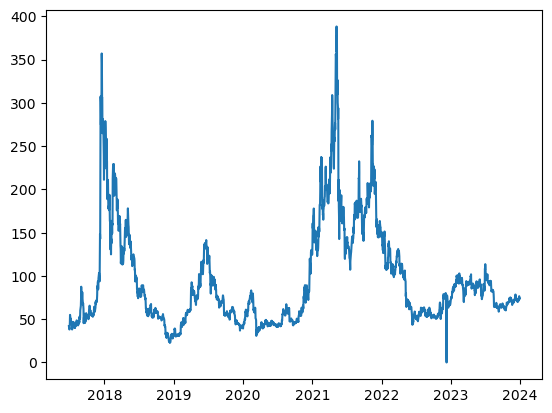

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2338, 30), (2338,), (2338,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1870, 30), (1870,), (234, 30), (234,), (234, 30), (234,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100


2023-12-31 16:39:30.559579: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


59/59 [==============================] - 1s 11ms/step - loss: 3.7902 - mean_absolute_error: 1.4135 - val_loss: 1.2686 - val_mean_absolute_error: 0.2751
Epoch 2/100
59/59 [==============================] - 0s 7ms/step - loss: 0.3228 - mean_absolute_error: 0.4926 - val_loss: 1.2746 - val_mean_absolute_error: 0.2521
Epoch 3/100
59/59 [==============================] - 0s 7ms/step - loss: 0.2077 - mean_absolute_error: 0.3769 - val_loss: 1.2234 - val_mean_absolute_error: 0.1829
Epoch 4/100
59/59 [==============================] - 0s 7ms/step - loss: 0.0300 - mean_absolute_error: 0.1295 - val_loss: 1.2289 - val_mean_absolute_error: 0.1632
Epoch 5/100
59/59 [==============================] - 0s 8ms/step - loss: 0.0184 - mean_absolute_error: 0.0984 - val_loss: 1.2286 - val_mean_absolute_error: 0.1519
Epoch 6/100
59/59 [==============================] - 0s 7ms/step - loss: 0.0136 - mean_absolute_error: 0.0848 - val_loss: 1.2498 - val_mean_absolute_error: 0.1952
Epoch 7/100
59/59 [==============

59/59 [==============================] - 0s 2ms/step


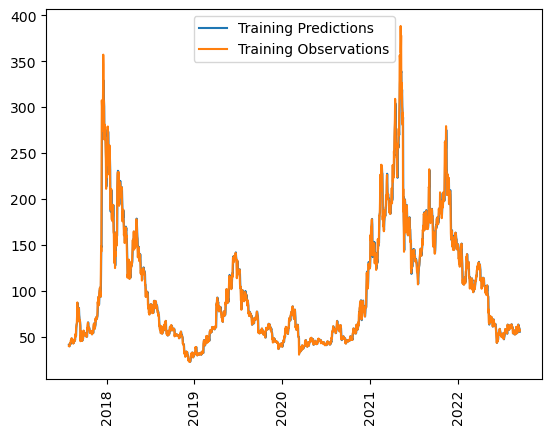

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 1.1370084285736084
Val MAE: 0.13128119707107544


8/8 [==============================] - 0s 3ms/step


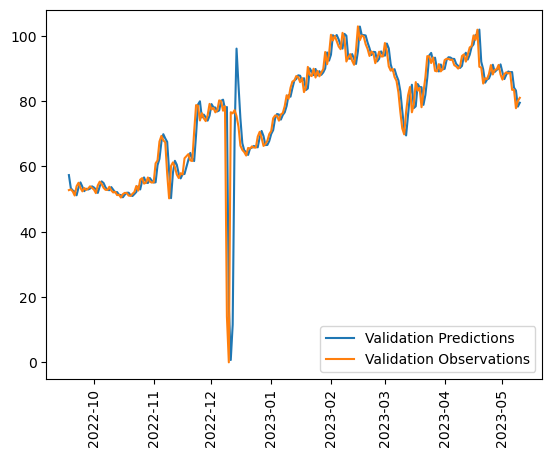

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.001120183034799993
Test MAE: 0.021657772362232208


8/8 [==============================] - 0s 3ms/step


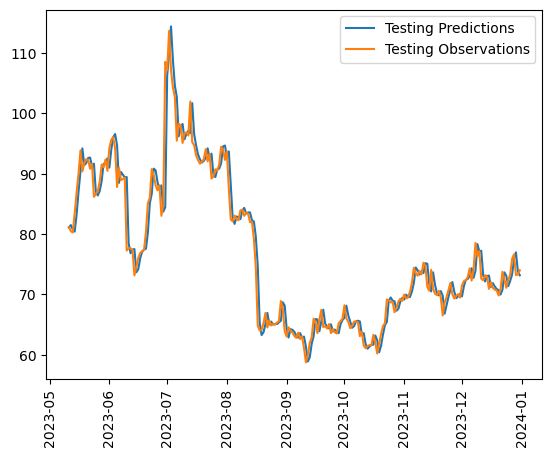

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.951390773542732


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((911,),
 (911, 30),
 (911,),
 (141,),
 (141, 30),
 (141,),
 (117,),
 (117, 30),
 (117,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
59/59 [==============================] - 1s 10ms/step - loss: 3.6687 - mean_absolute_error: 1.3736 - val_loss: 1.2949 - val_mean_absolute_error: 0.2603
Epoch 2/300
59/59 [==============================] - 0s 7ms/step - loss: 0.3152 - mean_absolute_error: 0.4870 - val_loss: 1.2908 - val_mean_absolute_error: 0.2493
Epoch 3/300
59/59 [==============================] - 0s 7ms/step - loss: 0.1611 - mean_absolute_error: 0.3224 - val_loss: 1.2330 - val_mean_absolute_error: 0.2352
Epoch 4/300
59/59 [==============================] - 0s 7ms/step - loss: 0.0325 - mean_absolute_error: 0.1344 - val_loss: 1.2267 - val_mean_absolute_error: 0.1798
Epoch 5/300
59/59 [==============================] - 0s 7ms/step - loss: 0.0242 - mean_absolute_error: 0.1172 - val_loss: 1.2263 - val_mean_absolute_error: 0.1671
Epoch 6/300
59/59 [==============================] - 0s 7ms/step - loss: 0.0191 - mean_absolute_error: 0.1014 - val_loss: 1.2284 - val_mean_absolute_error: 0.1541
Epoch 7/300
59/59 [==

59/59 [==============================] - 0s 2ms/step


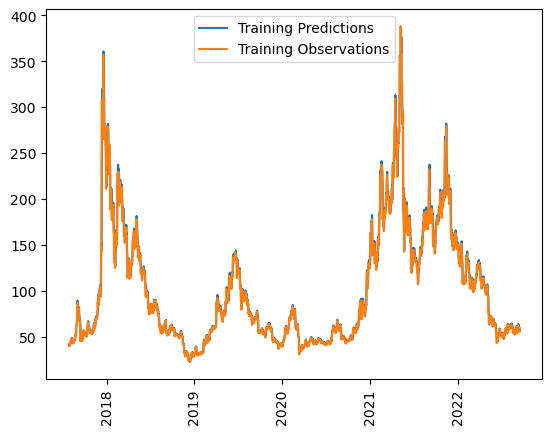

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00188441073987633
Val MAE: 0.028045352548360825


5/5 [==============================] - 0s 2ms/step


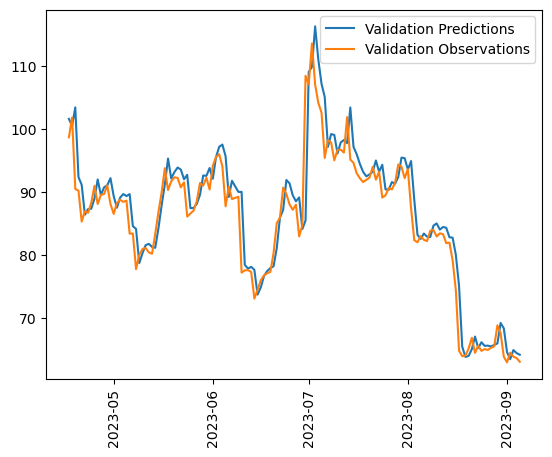

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0006778844399377704
Test MAE: 0.02017378993332386


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 2ms/step
R2 Score:  0.8435488339675047


4/4 [==============================] - 0s 2ms/step


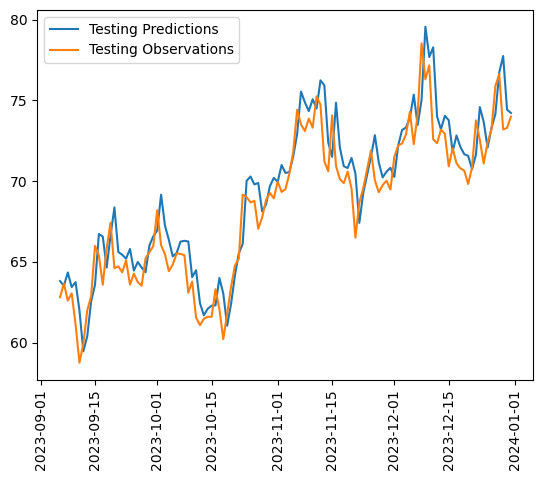

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
29/29 [==============================] - 1s 11ms/step - loss: 14.6083 - mean_absolute_error: 3.7763 - val_loss: 10.0601 - val_mean_absolute_error: 3.1695
Epoch 2/300
29/29 [==============================] - 0s 6ms/step - loss: 9.4824 - mean_absolute_error: 3.0155 - val_loss: 5.3326 - val_mean_absolute_error: 2.3061
Epoch 3/300
29/29 [==============================] - 0s 6ms/step - loss: 4.7724 - mean_absolute_error: 2.0713 - val_loss: 1.6525 - val_mean_absolute_error: 1.2796
Epoch 4/300
29/29 [==============================] - 0s 6ms/step - loss: 1.6844 - mean_absolute_error: 1.0653 - val_loss: 0.1116 - val_mean_absolute_error: 0.3086
Epoch 5/300
29/29 [==============================] - 0s 6ms/step - loss: 0.6367 - mean_absolute_error: 0.4826 - val_loss: 0.0504 - val_mean_absolute_error: 0.1881
Epoch 6/300
29/29 [==============================] - 0s 6ms/step - loss: 0.5608 - mean_absolute_error: 0.4329 - val_loss: 0.0749 - val_mean_absolute_error: 0.2429
Epoch 7/300
29/29 [

29/29 [==============================] - 0s 2ms/step


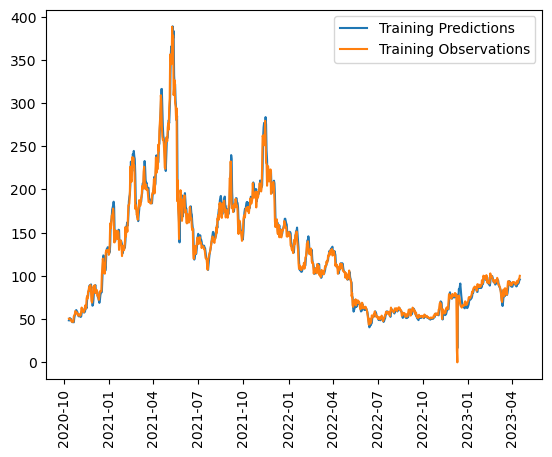

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0026946153957396746
Val MAE: 0.04059245437383652


5/5 [==============================] - 0s 2ms/step


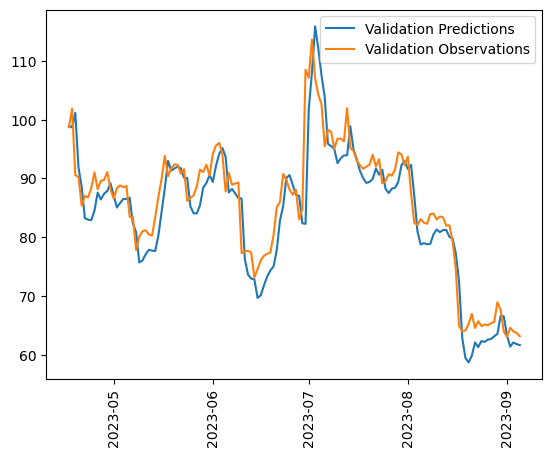

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0014079250395298004
Test MAE: 0.031511660665273666


4/4 [==============================] - 0s 2ms/step


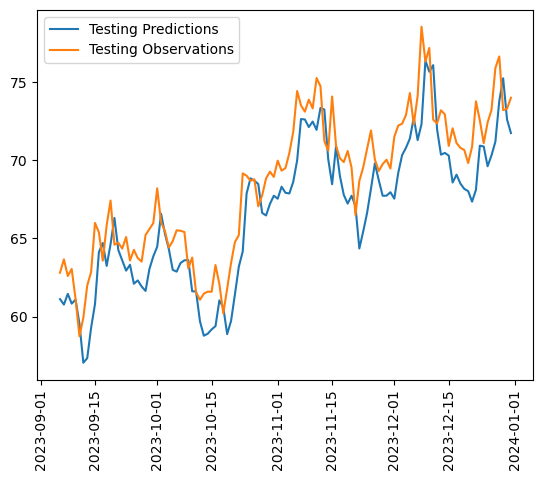

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.6750608453936308


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 9ms/step
[4.2926936, 4.294127, 4.295946, 4.2965307, 4.2964516, 4.2963023, 4.2962503]
2024-01-01
2024-01-02
2024-01-03
2024-01-04
2024-01-05
2024-01-06
2024-01-07


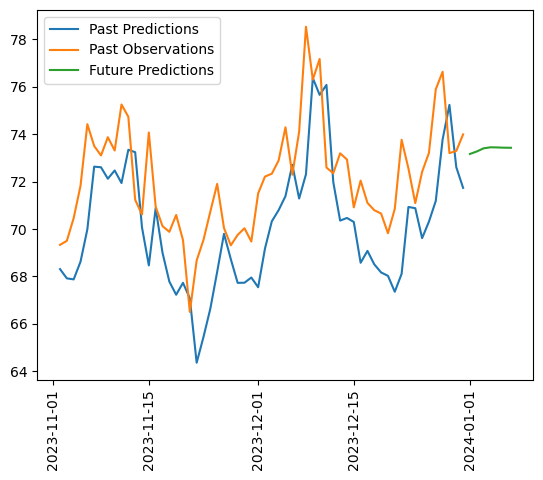

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-10-03,65.46,66.520508,67.242783,65.291641
2023-10-04,64.42,65.503067,66.360863,64.312286
2023-10-05,64.83,64.477699,65.337051,62.992573
2023-10-06,65.52,64.743050,65.546806,62.877575
2023-10-07,65.49,65.522873,66.251404,63.425598
...,...,...,...,...
2023-12-27,75.89,73.297958,74.151962,71.183304
2023-12-28,76.63,75.879921,76.731110,73.774315
2023-12-29,73.20,76.977013,77.746544,75.233292


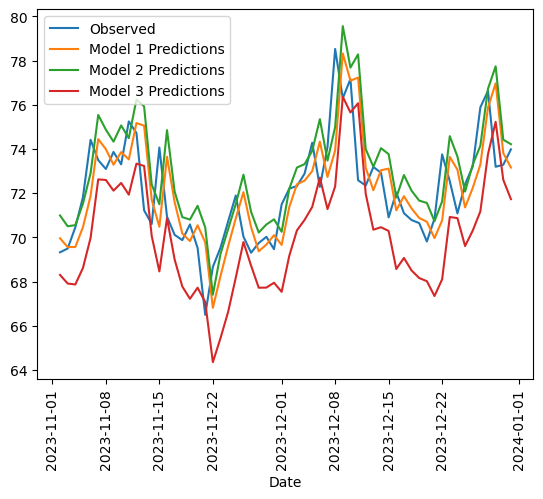

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.951390773542732
Model 2 R2 Score:  0.8435488339675047
Model 3 R2 Score:  0.6750608453936308
